In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
import os
sns.set(style="white")

In [28]:
FIG_PATH = "./figure/"
espl = pd.read_pickle("espl.pkl")
y = pd.read_pickle("./y-2s.pkl")

In [29]:
from funzioni import indice_gini
from funzioni import tasso_errata_classificazione

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [31]:
X_train, X_val, y_train, y_val = train_test_split(espl, y, test_size=0.25, random_state=42)

In [32]:
from sklearn.metrics import confusion_matrix

Accuratezza DecisionTreeClassifier(): 91.13%


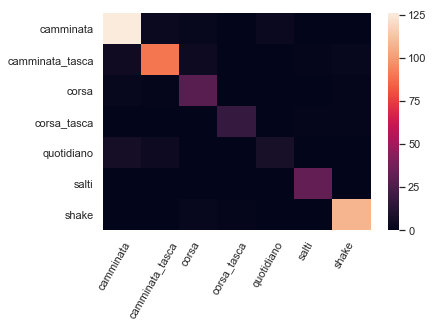

In [33]:
dtc = Pipeline([ 
    ("tree", DecisionTreeClassifier(random_state=42))
])

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_val)
dtc_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.2f}%".format(100 * dtc_acc))
sns.heatmap(confusion_matrix(y_val, y_pred), xticklabels=y.unique(), yticklabels=y.unique())
plt.xticks(np.arange(len(y.unique()))+0.3, y.unique(), rotation=60)
plt.show()

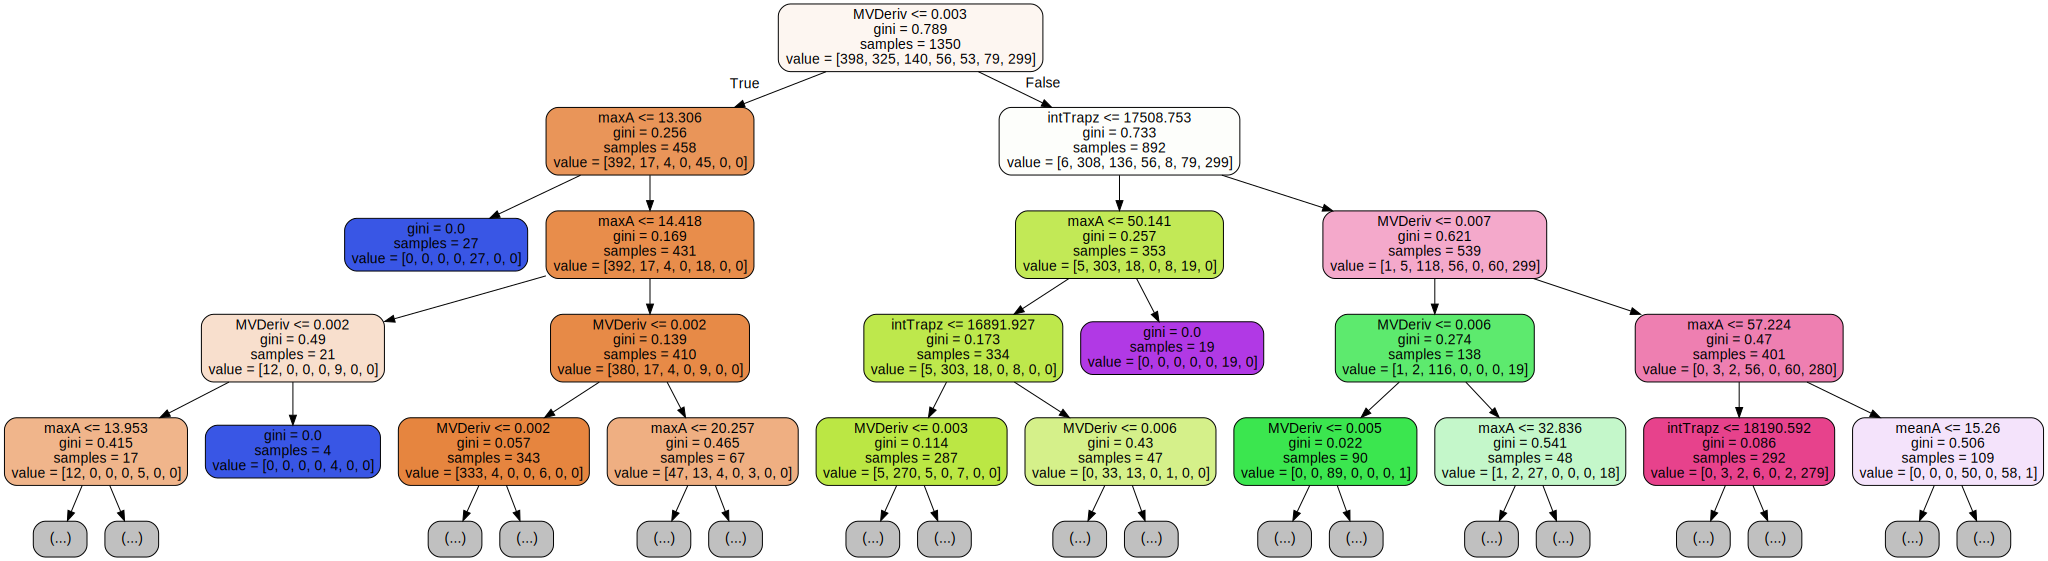

In [34]:
dot_data = export_graphviz(
    decision_tree=dtc.named_steps["tree"], 
    feature_names=espl.columns,
    max_depth=4,
    filled=True,
    rounded=True,
    node_ids=None
)
display(graphviz.Source(dot_data))

In [35]:
print("Profondità dell'albero allenato senza restrizioni: {}".format(dtc.named_steps["tree"].tree_.max_depth))
print("Massimo numero minimo di osservazioni in una foglia: {}".format(len(X_train) // 2))

Profondità dell'albero allenato senza restrizioni: 14
Massimo numero minimo di osservazioni in una foglia: 675


In [36]:
from sklearn.model_selection import ParameterGrid
import tqdm

In [37]:
2**9

512

In [38]:
param_grid = ParameterGrid({
    'tree__max_depth': np.arange(1, dtc.named_steps["tree"].tree_.max_depth),
    'tree__min_samples_leaf': 2 ** np.arange(10),
})
print(param_grid.param_grid)

[{'tree__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]), 'tree__min_samples_leaf': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512], dtype=int32)}]


In [39]:
risultati = []

for params in tqdm.tqdm(param_grid):
    dtc.set_params(**params)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_val)
    params["accuracy_score"] = accuracy_score(y_val, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "tree__max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|██████████████████████████████████████| 130/130 [00:01<00:00, 74.92it/s]


Primi 5:


,accuracy_score,tree__max_depth,tree__min_samples_leaf
0,0.929047,7,1
1,0.926829,5,1
2,0.926829,5,2
3,0.926829,5,4
4,0.926829,7,2


Ultimi 5:


,accuracy_score,tree__max_depth,tree__min_samples_leaf
125,0.507761,1,16
126,0.507761,1,32
127,0.507761,1,64
128,0.507761,1,128
129,0.507761,1,256


In [40]:
from funzioni import grafico_metrica_iperparametro

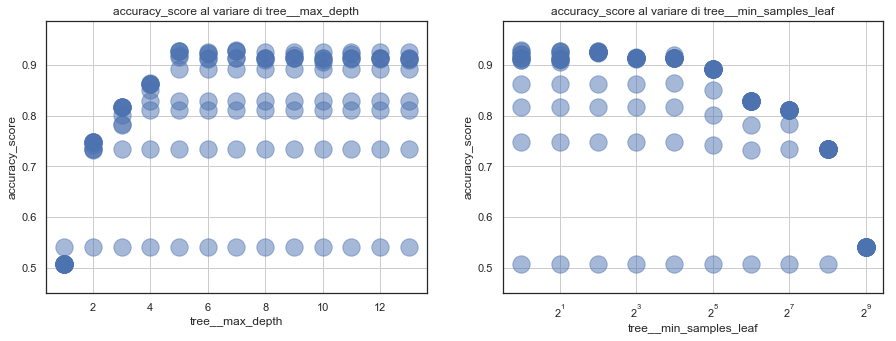

In [41]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
grafico_metrica_iperparametro(risultati, "tree__max_depth", "accuracy_score", alpha=0.5)

plt.subplot(122)
grafico_metrica_iperparametro(risultati, "tree__min_samples_leaf", "accuracy_score", alpha=0.5)
plt.xscale("log", basex=2)

plt.show()

#probabilmente una profondità massima di 4 e un numero minimo di unità per foglia pari a 4 o 8 sono sufficienti
#(vedi tabella risultati prime due righe)

In [42]:
from funzioni import grafico_metrica_iperparametri

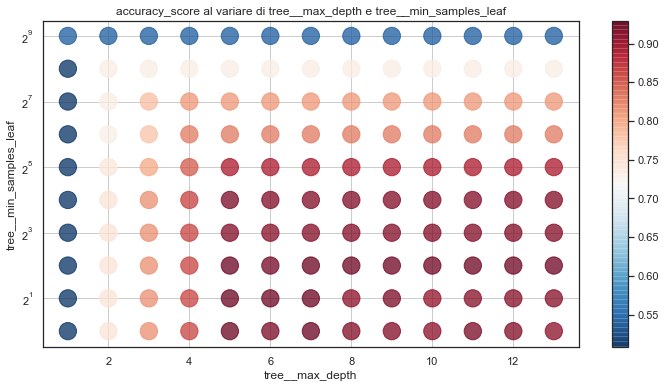

In [43]:
plt.figure(figsize=(12, 6))

grafico_metrica_iperparametri(risultati, "tree__max_depth", "tree__min_samples_leaf", "accuracy_score")
plt.yscale("log", basey=2)
plt.savefig(FIG_PATH + "iperparametri-Tree.png", dpi=200)
plt.show()

In [44]:
risultati.head(12)

,accuracy_score,tree__max_depth,tree__min_samples_leaf
0,0.929047,7,1
1,0.926829,5,1
2,0.926829,5,2
3,0.926829,5,4
4,0.926829,7,2
5,0.926829,7,4
6,0.924612,6,2
7,0.924612,8,4
8,0.924612,9,4
9,0.924612,10,4


In [45]:
from sklearn.impute import SimpleImputer

In [46]:
max_depth = risultati.loc[0, "tree__max_depth"]
min_samples_leaf = risultati.loc[0, "tree__min_samples_leaf"]

dtc_tun = Pipeline([
    ("tree", DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42))
])

dtc_tun.fit(X_train, y_train)

y_pred = dtc_tun.predict(X_val)
dtc_tun_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))

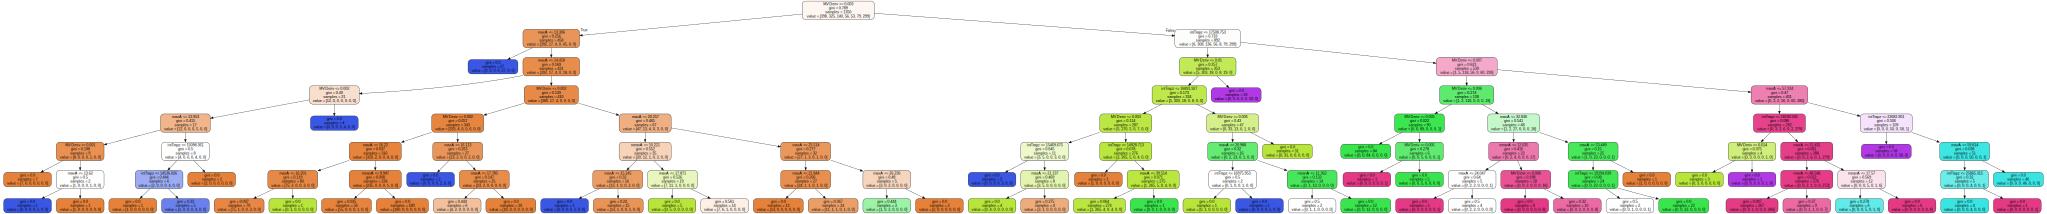

In [47]:
dot_data = export_graphviz(
    decision_tree=dtc_tun.named_steps["tree"],
    feature_names=espl.columns,
    filled=True,
    rounded=True,
    node_ids=None
)
display(graphviz.Source(dot_data))

Accuratezza DecisionTreeClassifier(): 91.1%
Accuratezza DecisionTreeClassifier(max_depth=7, min_samples_leaf=1): 92.9%
[[130   1   1   0   2   0   0]
 [  5  93   2   0   0   0   2]
 [  2   1  29   0   0   0   1]
 [  0   0   0  17   0   1   2]
 [  7   4   0   0   8   0   0]
 [  0   0   0   0   0  32   0]
 [  0   0   1   0   0   0 110]]


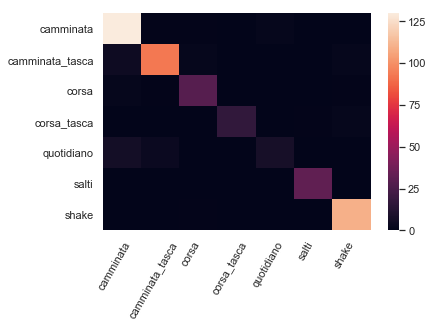

In [51]:
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(100 * dtc_acc))
print("Accuratezza DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): {:.1f}%".format(
    max_depth, min_samples_leaf, 100 * dtc_tun_acc))
print(confusion_matrix(y_val, y_pred))
sns.heatmap(confusion_matrix(y_val, y_pred), xticklabels=y.unique(), yticklabels=y.unique())
plt.xticks(np.arange(len(y.unique()))+0.3, y.unique(), rotation=60)
plt.savefig(FIG_PATH + "confusionMatrix-Tree.png", dpi=300, bbox_inches="tight")
plt.show()

In [49]:
from funzioni.grafici import grafico_importanza_variabili

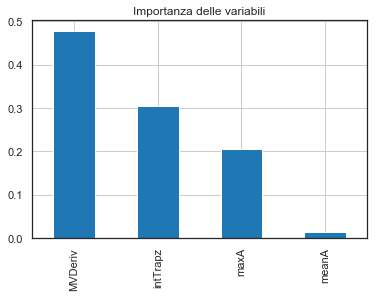

In [50]:
importanze = dtc_tun.named_steps["tree"].feature_importances_
variabili = espl.columns

grafico_importanza_variabili(importanze, variabili)
plt.savefig(FIG_PATH + "importance-Tree.png", dpi=300, bbox_inches="tight")
plt.show()